In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Set dataset paths and output directory
bank_additional_full_path = r'C:\Users\User\OneDrive\Desktop\INTERNSHIP\A Serious Company Pre Task\bank+marketing\bank-additional\bank-additional\bank-additional-full.csv'
bank_full_path = r'C:\Users\User\OneDrive\Desktop\INTERNSHIP\A Serious Company Pre Task\bank+marketing\bank\bank-full.csv'
output_dir = r'C:\Users\User\OneDrive\Desktop\INTERNSHIP\A Serious Company Pre Task\outputs'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


In [2]:
def load_and_preprocess_data(filepath):
    
    # Load dataset
    data = pd.read_csv(filepath, sep=';')

    # Encode categorical variables
    label_encoders = {}
    for col in data.select_dtypes(include='object').columns:
        if col != 'y':  # Exclude target variable
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le

    # Encode the target variable
    target_le = LabelEncoder()
    data['y'] = target_le.fit_transform(data['y'])

    # Normalize numerical features
    scaler = MinMaxScaler()
    numerical_cols = data.drop(columns=['y']).select_dtypes(include=['int64', 'float64']).columns
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    return data


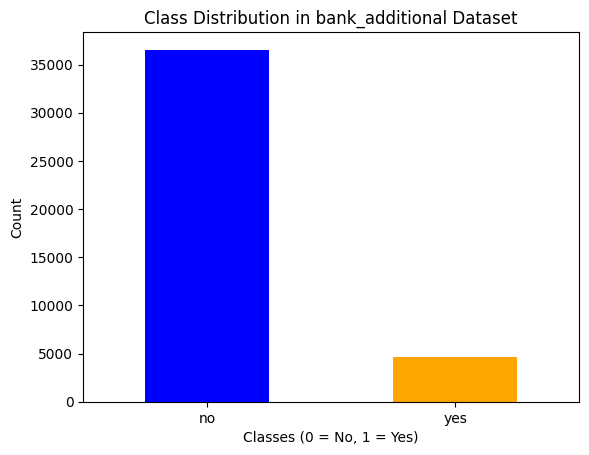

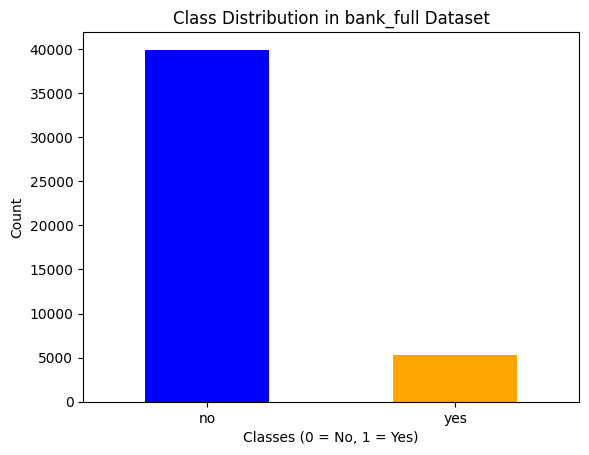

In [8]:
# Function to check class distribution
def check_class_distribution(filepath, dataset_name):
    """
    Check and visualize the class distribution of the target variable in the dataset.
    """
    # Load the dataset
    data = pd.read_csv(filepath, sep=';')

    # Get the class distribution of the target variable 'y'
    class_counts = data['y'].value_counts()  # Get the count of each class in 'y'
    
    # Plot the class distribution
    class_counts.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f"Class Distribution in {dataset_name} Dataset")
    plt.xlabel("Classes (0 = No, 1 = Yes)")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# Check class distribution for both datasets
check_class_distribution(bank_additional_full_path, "bank_additional")
check_class_distribution(bank_full_path, "bank_full")


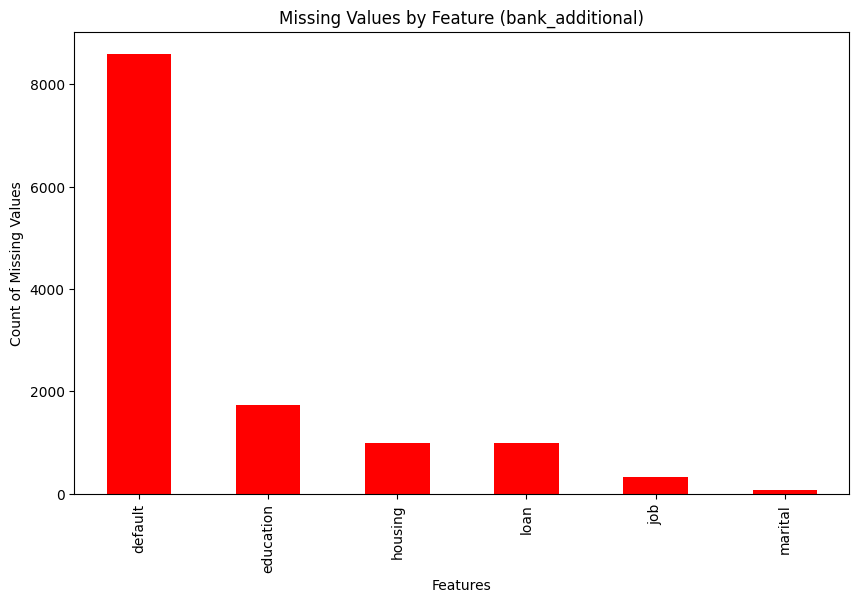

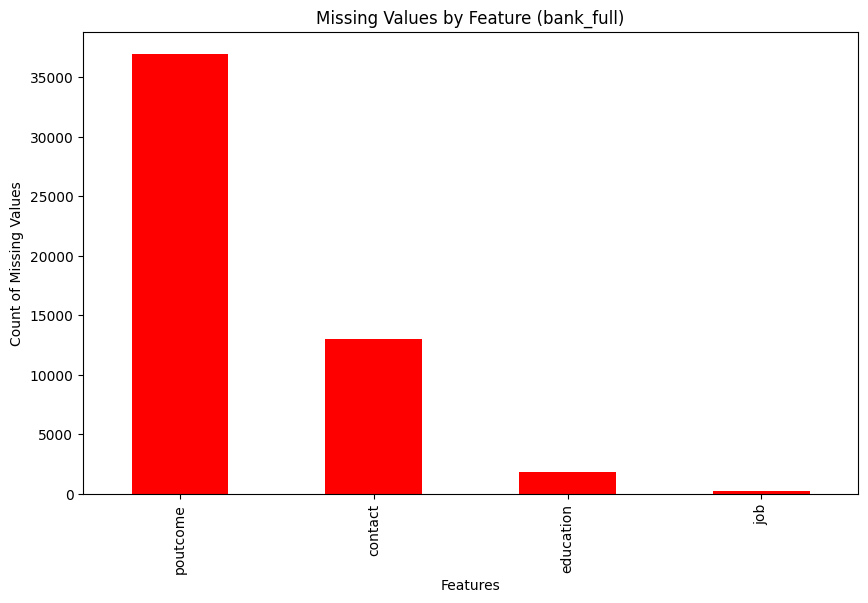

In [3]:
def visualize_missing_values(data, dataset_name):
    
    # Calculate missing values per column
    missing_values = data.isna().sum()
    missing_values = missing_values[missing_values > 0]  # Filter columns with missing values only

    if not missing_values.empty: 
        plt.figure(figsize=(10, 6))
        missing_values.sort_values(ascending=False).plot(kind='bar', color='red')
        plt.title(f"Missing Values by Feature ({dataset_name})")
        plt.xlabel("Features")
        plt.ylabel("Count of Missing Values")
        plt.show()
    else:
        print(f"No missing values in the {dataset_name} dataset.")

# Load and visualize missing values for the datasets
data_additional = pd.read_csv(bank_additional_full_path, sep=';')
data_additional.replace('unknown', pd.NA, inplace=True)
visualize_missing_values(data_additional, "bank_additional")

data_full = pd.read_csv(bank_full_path, sep=';')
data_full.replace('unknown', pd.NA, inplace=True)
visualize_missing_values(data_full, "bank_full")



Handling missing values...


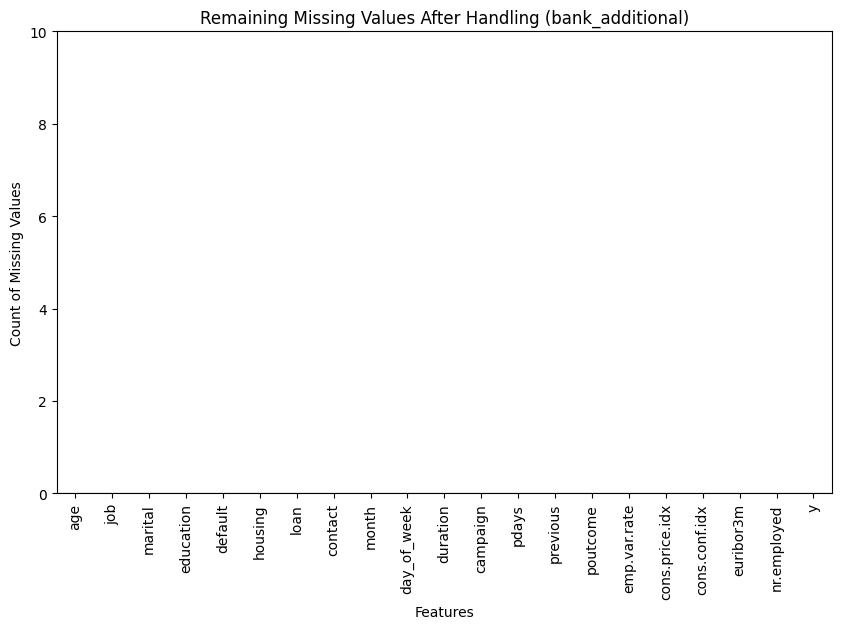

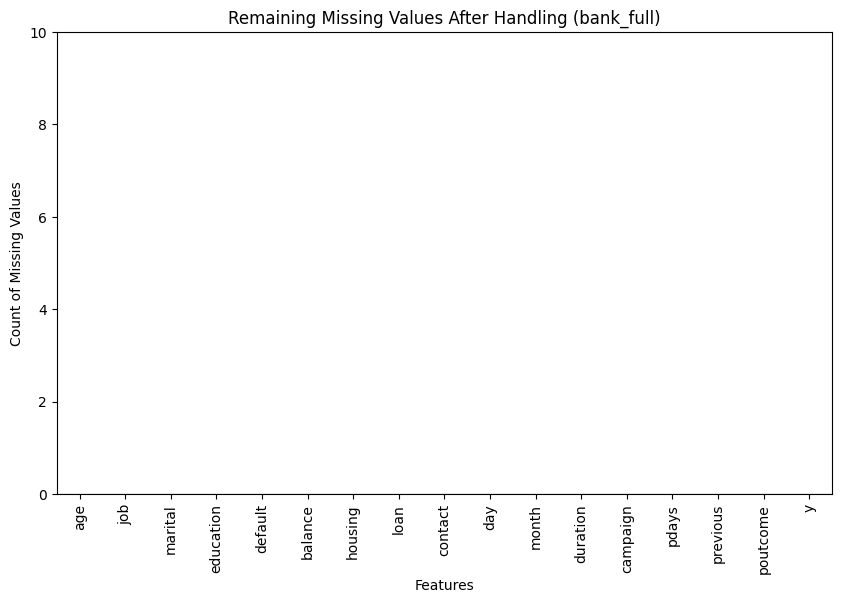

In [5]:
# Bar chart function to visualize remaining missing values after handling
def visualize_remaining_missing(data, dataset_name):
    """
    Visualize remaining missing values after handling.
    Shows a bar chart with zero missing values if none remain.
    """
    missing_values = data.isna().sum()

    plt.figure(figsize=(10, 6))
    missing_values.plot(kind='bar', color='green')
    plt.title(f"Remaining Missing Values After Handling ({dataset_name})")
    plt.xlabel("Features")
    plt.ylabel("Count of Missing Values")
    plt.ylim(0, 10)  
    plt.axhline(0, color="black", linewidth=0.8)  
    plt.show()

# Handle missing values: Impute missing values with the mode for both datasets
print("\nHandling missing values...")

# Impute missing values in bank-additional-full.csv
data_additional.fillna(data_additional.mode().iloc[0], inplace=True)

# Impute missing values in bank-full.csv
data_full.fillna(data_full.mode().iloc[0], inplace=True)

# Visualize remaining missing values for bank-additional-full.csv
visualize_remaining_missing(data_additional, "bank_additional")

# Visualize remaining missing values for bank-full.csv
visualize_remaining_missing(data_full, "bank_full")


In [6]:
def train_and_evaluate_model(data, dataset_name):

    # Split data into train and test sets
    X = data.drop(columns=['y'])
    y = data['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Hyperparameter tuning for k-NN
    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    knn_grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid=knn_param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )
    knn_grid_search.fit(X_train, y_train)

    # Extract k-NN results
    knn_model_tuned = knn_grid_search.best_estimator_
    knn_auc_score_cv = knn_grid_search.best_score_

    # Hyperparameter tuning for Random Forest
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    }
    rf_grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=rf_param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )
    rf_grid_search.fit(X_train, y_train)

    # Extract Random Forest results
    rf_model_tuned = rf_grid_search.best_estimator_
    rf_auc_score_cv = rf_grid_search.best_score_

    # Evaluate models
    y_pred_proba_knn = knn_model_tuned.predict_proba(X_test)[:, 1]
    y_pred_proba_rf = rf_model_tuned.predict_proba(X_test)[:, 1]

    knn_auc_score_test = roc_auc_score(y_test, y_pred_proba_knn)
    rf_auc_score_test = roc_auc_score(y_test, y_pred_proba_rf)

    knn_classification_report = classification_report(y_test, knn_model_tuned.predict(X_test))
    rf_classification_report = classification_report(y_test, rf_model_tuned.predict(X_test))

    # Print evaluation results
    print(f"--- {dataset_name} Dataset ---")
    print(f"k-NN Cross-Validated AUC-ROC: {knn_auc_score_cv:.2f}")
    print(f"Random Forest Cross-Validated AUC-ROC: {rf_auc_score_cv:.2f}\n")
    print("k-NN Classification Report:\n", knn_classification_report)
    print(f"k-NN Test AUC-ROC: {knn_auc_score_test:.2f}\n")
    print("Random Forest Classification Report:\n", rf_classification_report)
    print(f"Random Forest Test AUC-ROC: {rf_auc_score_test:.2f}\n")

    # Generate ROC curves
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {knn_auc_score_test:.2f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc_score_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(f'ROC Curve Comparison ({dataset_name} Dataset)', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend()

    # Save the ROC plot
    roc_plot_path = os.path.join(output_dir, f'roc_curve_comparison_{dataset_name}.png')
    plt.savefig(roc_plot_path)
    plt.show()



Processing 'bank-additional-full.csv'...
--- bank_additional Dataset ---
k-NN Cross-Validated AUC-ROC: 0.78
Random Forest Cross-Validated AUC-ROC: 0.95

k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10965
           1       0.61      0.22      0.33      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.60      0.64     12357
weighted avg       0.87      0.90      0.87     12357

k-NN Test AUC-ROC: 0.80

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     10965
           1       0.54      0.84      0.65      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.87      0.80     12357
weighted avg       0.93      0.90      0.91     12357

Random Forest Test AUC-ROC: 0.95



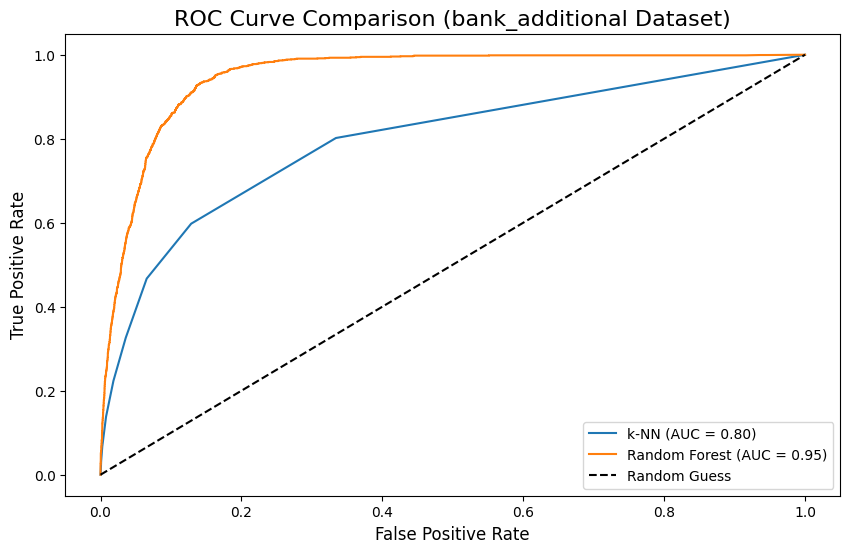


Processing 'bank-full.csv'...
--- bank_full Dataset ---
k-NN Cross-Validated AUC-ROC: 0.77
Random Forest Cross-Validated AUC-ROC: 0.92

k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.62      0.23      0.33      1587

    accuracy                           0.89     13564
   macro avg       0.76      0.60      0.64     13564
weighted avg       0.87      0.89      0.87     13564

k-NN Test AUC-ROC: 0.78

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94     11977
           1       0.59      0.55      0.57      1587

    accuracy                           0.90     13564
   macro avg       0.76      0.75      0.76     13564
weighted avg       0.90      0.90      0.90     13564

Random Forest Test AUC-ROC: 0.92



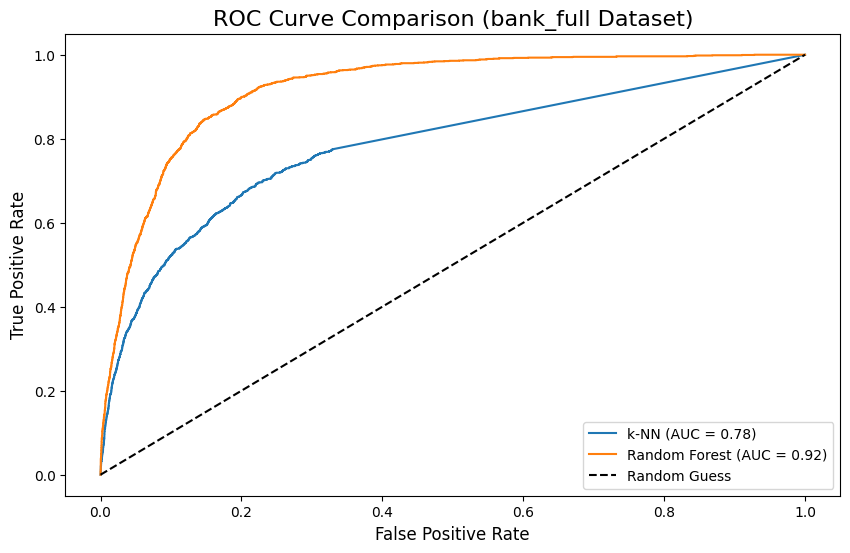

In [7]:
# Process and evaluate for 'bank-additional-full.csv'
print("Processing 'bank-additional-full.csv'...")
bank_additional_data = load_and_preprocess_data(bank_additional_full_path)
train_and_evaluate_model(bank_additional_data, dataset_name='bank_additional')

# Process and evaluate for 'bank-full.csv'
print("\nProcessing 'bank-full.csv'...")
bank_data = load_and_preprocess_data(bank_full_path)
train_and_evaluate_model(bank_data, dataset_name='bank_full')
